In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG
from train import train1Epoch
from train import test1Epoch
from datasetCreator import ImageSubset
torch.cuda.empty_cache()
import seaborn as sns

import os
import cv2

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!del /Q /S /F runs\*
#!rmdir /S /Q runs

In [4]:
torch.cuda.is_available(), torch.version.cuda

(True, '11.7')

%load_ext tensorboard
torch.backends.cudnn.benchmark = True
writer=SummaryWriter()
%tensorboard --logdir='runs/' --inspect

!start chrome http://localhost:6006/

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

!pip install https://download.pytorch.org/whl/nightly/cu117/torch-1.14.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/nightly/cu117/torchvision-0.15.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
torch.cuda.is_available(), torch.version.cuda

In [3]:
DATA_PATH = '/home/mmorocho/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv'
KEY_PATH = '/home/mmorocho/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv'

df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')
#missing h5py files 7-9

cols= ['unique_key', 'bnpp_value_log', 'BNP_value' 
        #'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime'
       ]
test_df = pd.read_csv('/home/mmorocho/teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('/home/mmorocho/teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('/home/mmorocho/teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv', usecols = cols).set_index('unique_key')
print(train_df.shape, test_df.shape, val_df.shape)
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))


train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
print(train_df.shape, test_df.shape, val_df.shape)

train_df['filepaths'] = train_df['filepaths'].str.replace('jmryan','mmorocho')
test_df['filepaths'] = test_df['filepaths'].str.replace('jmryan','mmorocho')
val_df['filepaths'] = val_df['filepaths'].str.replace('jmryan','mmorocho')
new_valid = pd.concat([test_df,val_df],ignore_index=False)
train_df.shape, test_df.shape, val_df.shape,new_valid.shape

train_df.reset_index(names='unique_key',inplace=True)
val_df.reset_index(names='unique_key',inplace=True)
test_df.reset_index(names='unique_key',inplace=True)
new_valid.reset_index(names='unique_key',inplace=True)

train_df = train_df.to_numpy()
new_valid = new_valid.to_numpy()
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()

(21374, 2) (2602, 2) (2692, 2)
(15164, 4) (1823, 4) (1913, 4)


In [4]:
#from zmq import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df[idx,:]
        #plt.imshow(im,cmap='gray')
        #plt.show()
        #returns image, bnpp value log, binary variable for edema
        
        #resnet
        return torch.load(row[4]).view(1, 224, 224).expand(3, -1, -1), row[1], row[3]
    
        #vgg?
        #return torch.load(row[4]).view(1, 224, 224), row[1], row[3]

In [5]:
batch_size = 16 #maybe change to 16, 8
num_workers = 2
pin_memory = True
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = PreprocessedImageDataset(df=train_df) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = PreprocessedImageDataset(df=val_df) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

#print(train_set[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))
#len(valid_set)
test_set = PreprocessedImageDataset(df=test_df)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 5): 
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

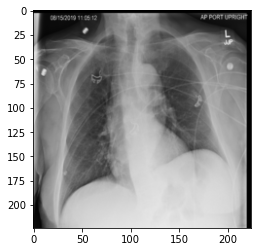

In [6]:
plt.imshow(valid_set[0][0].permute(1, 2, 0),cmap='gray')

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = 'ResNet'
if model == 'VGG16':
    model = VGG('VGG16').to(device)
elif model == 'ResNet':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights='DEFAULT')
    model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    model.to(device)
model

cuda


Using cache found in /home/mmorocho/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys_r")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, _ = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

[INFO]: Computation device: cuda
[INFO]: 58,145,857 total parameters.
[INFO]: 58,145,857 trainable parameters.


In [9]:
os.environ['NUM_GPU']='1'

In [10]:

# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 15
#best_vloss = 1_000_000.

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses, vlosses = np.array([]),np.array([])
# writer.add_text('model params', \
#                 f'''VGG16\n
#                 loss: {'MAE'}\n
#                 optimizer: {'Adam'}\n
#                 \tlearn rate: {LR}\n
#                 \trho: {RHO}\n
#                 batch size: {batch_size}\n
#                 nodes: {500}\n
#                 dropout: {0}\n
#                 batchnorm: {'yes'}\n
#                 RELU: {'Leaky'}\n
#                 epochs: {EPOCHS}
#                 ''',\
#                 0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

#     for param in model.parameters():
#         param.requires_grad = True
    #avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    for param in model.parameters():
        param.requires_grad = True
    avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    
    
#     for param in model.parameters():
#         param.requires_grad = False
#     with torch.no_grad():
#         avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)
    for param in model.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))
    #writer.add_scalars('Loss', {'train':avg_tloss,'test':avg_vloss}, epoch)
#     tlosses.append(avg_tloss)
#     vlosses.append(avg_vloss)
    tlosses = np.append(tlosses,avg_tloss)
    vlosses = np.append(vlosses,avg_vloss)
    print(tlosses)

    epoch_number += 1
    scheduler.step(avg_vloss)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
#writer.flush()
#writer.close()

EPOCH 1:


100%|██████████| 120/120 [00:07<00:00, 15.47it/s]

LOSS train 0.6024685215703295 valid 0.531366472532558
[0.60246852]
EPOCH 2:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function un

LOSS train 0.47898111676337685 valid 0.49523651907967364
[0.60246852 0.47898112]
EPOCH 3:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.42150813753269617 valid 0.4923167894663383
[0.60246852 0.47898112 0.42150814]
EPOCH 4:



  6%|▌         | 56/948 [00:14<03:51,  3.86it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  6%|▌         | 57/948 [00:15<03:55,  3.79it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.37112842918145766 valid 0.5061559425400205
[0.60246852 0.47898112 0.42150814 0.37112843]
EPOCH 5:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.3345513201171889 valid 0.495157897390931
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132]
EPOCH 6:



  6%|▌         | 57/948 [00:15<03:53,  3.81it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  6%|▌         | 58/948 [00:15<03:55,  3.78it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.306216164005337 valid 0.478319345520599
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616]
EPOCH 7:



  0%|          | 0/948 [00:00<?, ?it/s]/home/mmorocho/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/mmorocho/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/mmorocho/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/mmorocho/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped()

LOSS train 0.27597341716525703 valid 0.4775011939710477
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342]
EPOCH 8:



  3%|▎         | 24/948 [00:06<03:55,  3.92it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  3%|▎         | 25/948 [00:06<03:54,  3.93it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.257288021695588 valid 0.4746172673637837
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802]
EPOCH 9:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.24700480022911575 valid 0.4708280088224337
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802 0.2470048 ]
EPOCH 10:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.23189379316546946 valid 0.47826843091160076
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802 0.2470048  0.23189379]
EPOCH 11:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.2170994235803874 valid 0.4677546600744671
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802 0.2470048  0.23189379 0.21709942]
EPOCH 12:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.21064592818539113 valid 0.4628164410606665
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802 0.2470048  0.23189379 0.21709942 0.21064593]
EPOCH 13:



  8%|▊         | 78/948 [00:20<03:42,  3.92it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  8%|▊         | 79/948 [00:20<03:41,  3.92it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.20353100215224396 valid 0.4735303621934236
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802 0.2470048  0.23189379 0.21709942 0.21064593
 0.203531  ]
EPOCH 14:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.1912894134414328 valid 0.46194419392179625
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802 0.2470048  0.23189379 0.21709942 0.21064593
 0.203531   0.19128941]
EPOCH 15:



  6%|▌         | 54/948 [00:13<03:47,  3.94it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  6%|▌         | 55/948 [00:14<03:46,  3.94it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.18755407760455173 valid 0.4658775803625809
[0.60246852 0.47898112 0.42150814 0.37112843 0.33455132 0.30621616
 0.27597342 0.25728802 0.2470048  0.23189379 0.21709942 0.21064593
 0.203531   0.19128941 0.18755408]


In [11]:
#loss on unseen test set
for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, model, loss_fn, test_loader)
print(test_loss)

  1%|▏         | 25/1823 [00:00<00:56, 31.98it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (

0.46322459409010996


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


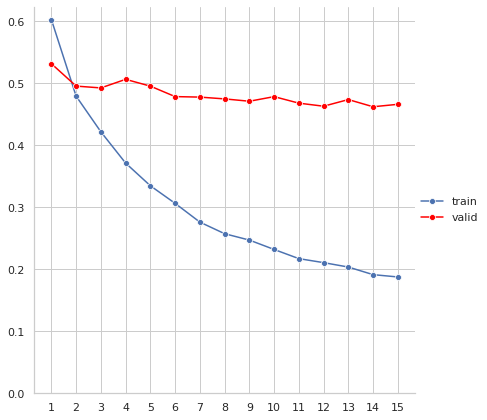

In [12]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses,'valid loss':vlosses})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### VGG SECTION

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model2 = 'VGG16'
if model2 == 'VGG16':
    model2 = VGG('VGG16').to(device)
elif model2 == 'ResNet':
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights='DEFAULT')
    model2.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    model2.to(device)
model2

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxP

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model2.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model2.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

[INFO]: Computation device: cuda
[INFO]: 27,514,413 total parameters.
[INFO]: 27,514,413 trainable parameters.


In [15]:
# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 15
#best_vloss = 1_000_000.

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses2, vlosses2 = np.array([]),np.array([])
# writer.add_text('model params', \
#                 f'''VGG16\n
#                 loss: {'MAE'}\n
#                 optimizer: {'Adam'}\n
#                 \tlearn rate: {LR}\n
#                 \trho: {RHO}\n
#                 batch size: {batch_size}\n
#                 nodes: {500}\n
#                 dropout: {0}\n
#                 batchnorm: {'yes'}\n
#                 RELU: {'Leaky'}\n
#                 epochs: {EPOCHS}
#                 ''',\
#                 0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

#     for param in model.parameters():
#         param.requires_grad = True
    #avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    for param in model2.parameters():
        param.requires_grad = True
    avg_tloss2 = train1Epoch(epoch_number, model2, optimizer, loss_fn, train_loader)#, writer)
    
    
#     for param in model.parameters():
#         param.requires_grad = False
#     with torch.no_grad():
#         avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)
    for param in model2.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss2 = test1Epoch(epoch_number, model2, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss2, avg_vloss2))
    #writer.add_scalars('Loss', {'train':avg_tloss,'test':avg_vloss}, epoch)
    tlosses2 = np.append(tlosses2,avg_tloss2)
    vlosses2 = np.append(vlosses2,avg_vloss2)

    epoch_number += 1
    scheduler.step(avg_vloss2)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
#writer.flush()
#writer.close()

EPOCH 1:


 63%|██████▎   | 76/120 [00:03<00:01, 23.63it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
100%|██████████| 120/120 [00:05<00:00, 22.95it/s]

LOSS train 0.8190502972251131 valid 0.6945595421175228
EPOCH 2:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  8%|▊         | 76/948 [00:11<02:07,  6.86it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning:

LOSS train 0.6430772668271078 valid 0.565953552329908
EPOCH 3:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  7%|▋         | 62/948 [00:09<02:09,  6.85it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning:

100%|██████████| 120/120 [00:05<00:00, 22.85it/s]

LOSS train 0.6145746457490796 valid 0.5465114970880384
EPOCH 4:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

100%|██████████| 120/120 [00:05<00:00, 23.08it/s]

LOSS train 0.594137092475503 valid 0.5159121610958604
EPOCH 5:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  5%|▍         | 44/948 [00:06<02:11,  6.86it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning:

100%|██████████| 120/120 [00:05<00:00, 22.87it/s]

LOSS train 0.5800005531628885 valid 0.5266820541708453
EPOCH 6:



  4%|▎         | 34/948 [00:05<02:13,  6.85it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (func

100%|██████████| 120/120 [00:05<00:00, 23.01it/s]

LOSS train 0.5722761211717439 valid 0.5253518436206416
EPOCH 7:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

100%|██████████| 120/120 [00:05<00:00, 23.01it/s]

LOSS train 0.5663732804925506 valid 0.5239948875844297
EPOCH 8:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  2%|▏         | 18/948 [00:02<02:16,  6.82it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning:

100%|██████████| 120/120 [00:05<00:00, 22.95it/s]

LOSS train 0.5577863302260659 valid 0.49418907808557827
EPOCH 9:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.550718358897292 valid 0.4931607513142909
EPOCH 10:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function unch

  1%|          | 1/120 [00:00<00:12,  9.24it/s]/home/mmorocho/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/mmorocho/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
100%|██████████| 120/120 [00:05<00:00, 22.87it/s]

LOSS train 0.5412573552425499 valid 0.49769765605273864
EPOCH 11:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.5404381226022558 valid 0.4939888689488955
EPOCH 12:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
 10%|▉         | 94/948 [00:13<02:04,  6.83it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning:

LOSS train 0.5334868890067536 valid 0.494220523446711
EPOCH 13:



  9%|▉         | 88/948 [00:12<02:05,  6.83it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  9%|▉         | 89/948 [00:13<02:05,  6.83it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.5239233077499653 valid 0.5047302921514205
EPOCH 14:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.5203590562164689 valid 0.5049407683729703
EPOCH 15:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  6%|▋         | 61/948 [00:08<02:09,  6.84it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning:

LOSS train 0.5145515550907152 valid 0.5123761287204468


In [16]:
#loss on unseen test set
for param in model2.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, model2, loss_fn, test_loader)
print(test_loss)

  1%|▏         | 27/1823 [00:00<00:12, 141.25it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: initialization error (fun

0.5154180053074774


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


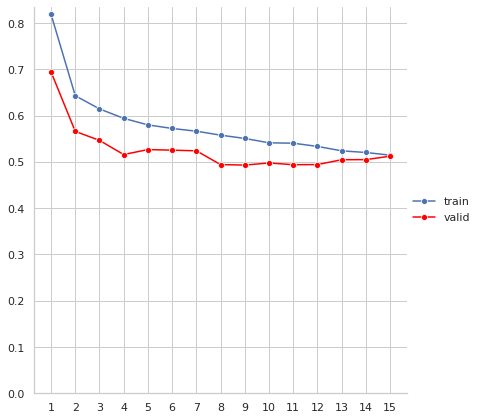

In [17]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses2,'valid loss':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses2,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


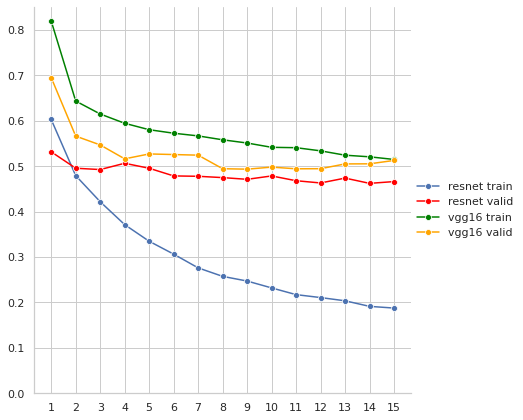

In [19]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss resnet': tlosses,'valid loss resnet':vlosses, 'train loss vgg': tlosses2,'valid loss vgg':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='resnet train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='resnet valid')
g = g.map(sns.lineplot, x=epochs,y=tlosses2,color='green',marker='o', label='vgg16 train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='orange',marker='o', label='vgg16 valid')

g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### Resnet AUC work

In [20]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, hearts = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = model(image)
            hearts = np.append(hearts, heart)
            #preds = np.append(preds, pred.item())
            preds = np.append(preds, pred.cpu())

100%|██████████| 1823/1823 [01:01<00:00, 29.43it/s]


In [21]:
preds

array([2.37458849, 2.58035922, 2.40372252, ..., 1.91640151, 1.91108346,
       3.2039721 ])

In [22]:
prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()

In [23]:
np.power(10,np.log10(400))/(np.power(10,preds)).sum()

8.26920137002997e-05

In [24]:
y_preds = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())
y_preds.sum()

1152

In [46]:
hearts

array([1., 0., 1., ..., 0., 1., 1.])

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts, y_preds)
print('Confusion matrix')
print(cf_mat)
print()
cf_mat_norm = confusion_matrix(hearts, y_preds,normalize='true')
print(cf_mat_norm)

accuracy score: 0.7888096544157981

TN: 492
FP: 206
FN: 179
TP: 946

Confusion matrix
[[492 206]
 [179 946]]

[[0.70487106 0.29512894]
 [0.15911111 0.84088889]]


### VGG16 AUC Work

In [27]:
model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds2, hearts2 = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = model2(image)
            hearts2 = np.append(hearts2, heart)
            #preds = np.append(preds, pred.item())
            preds2 = np.append(preds2, pred.cpu())

100%|██████████| 1823/1823 [00:08<00:00, 203.94it/s]


In [28]:
prob_preds2 = np.power(10,preds2) / (np.power(10,preds2)).sum()

In [29]:
np.power(10,np.log10(400))/(np.power(10,preds2)).sum()

0.00017442483214947184

In [30]:
y_preds2 = prob_preds2 > (np.power(10,np.log10(400))/(np.power(10,preds2)).sum())
y_preds2.sum()

1018

In [45]:
hearts2

array([1., 0., 1., ..., 0., 1., 1.])

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts2, y_preds2)}')
tn, fp, fn, tp = confusion_matrix(hearts2, y_preds2).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts2, y_preds2)
print('Confusion matrix')
print(cf_mat)
print()
cf_mat_norm = confusion_matrix(hearts2, y_preds2,normalize='true')
print(cf_mat_norm)

accuracy score: 0.7712561711464618

TN: 543
FP: 155
FN: 262
TP: 863

Confusion matrix
[[543 155]
 [262 863]]

[[0.77793696 0.22206304]
 [0.23288889 0.76711111]]


### Combined AUC Curves

In [33]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [42]:
#plot_roc_curve(hearts, y_preds)
#print(f'model 1 AUC score: {roc_auc_score(hearts, y_preds)}')

In [43]:
#plot_roc_curve(hearts, preds)
#print(f'model 1 AUC score: {roc_auc_score(hearts, prob_preds)}')

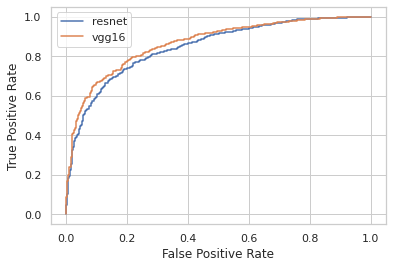

In [41]:
plot_roc_curve(hearts2,preds2)
plot_roc_curve(hearts,preds)
plt.gca().legend(('resnet','vgg16'))

torch.save(model, '/home/ddavilag/private/DSC180A/DSC180A')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, '/home/ddavilag/private/DSC180A/DSC180A/VGG16_1.pt')

#Loading the model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()